In [11]:
import csv
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing
import numpy as np
import matplotlib as plt
from pandas.tools.plotting import scatter_matrix
%matplotlib inline

In [2]:
df = pd.read_csv("cereals.csv")

In [3]:
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
0,100%_Bran,N,C,70,4,1,130,10,5,6,280,25,3,1,0.33
1,100%_Natural_Bran,Q,C,120,3,5,15,2,8,8,135,0,3,1,1.00
2,All-Bran,K,C,70,4,1,260,9,7,5,320,25,3,1,0.33
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14,8,0,330,25,3,1,0.50
4,Almond_Delight,R,C,110,2,2,200,1,14,8,-1,25,3,1,0.75


Looking at this, it's clear that we will have to do something about "mfr" and "type" colummns because they are not numbers. To get some ennumeration, I'm looking at the value counts of them to see if 1) they are important and 2) to get a use-weighted integer to assign to the contents.

## Cleaning Data

In [4]:
df = df.reindex(np.random.permutation(df.index)) # randomize order of data

In [5]:
for col in df.columns:
    print(col.ljust(15)+str(min(df[col])))

name           100%_Bran
mfr            A
type           C
calories       50
protein        1
fat            0
sodium         0
fiber          0.0
carbo          -1.0
sugars         -1
potass         -1
vitamins       0
shelf          1
weight         0.5
cups           0.25


In [6]:
replace_cols = ["carbo", "sugars", "potass"]

In [7]:
avg_cols = [0]*3
for i in range(3):
    avg_cols[i] = sum(df[replace_cols[i]]) / len(df[replace_cols[i]])

In [8]:
for i in range(3): # replace missing things with average value
    col = replace_cols[i]
    df[col] = df[col].replace(-1, avg_cols[i])

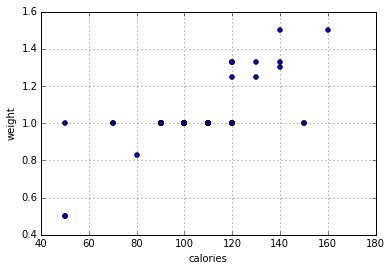

In [9]:
df.plot(kind="scatter", x="calories", y="weight")

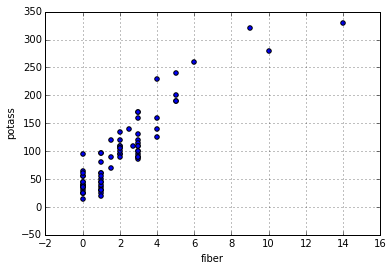

In [10]:
df.plot(kind="scatter", x="fiber", y="potass")

Weight and calories are not equivelant, and cups isn't either.

In [12]:
corr = df.corr()

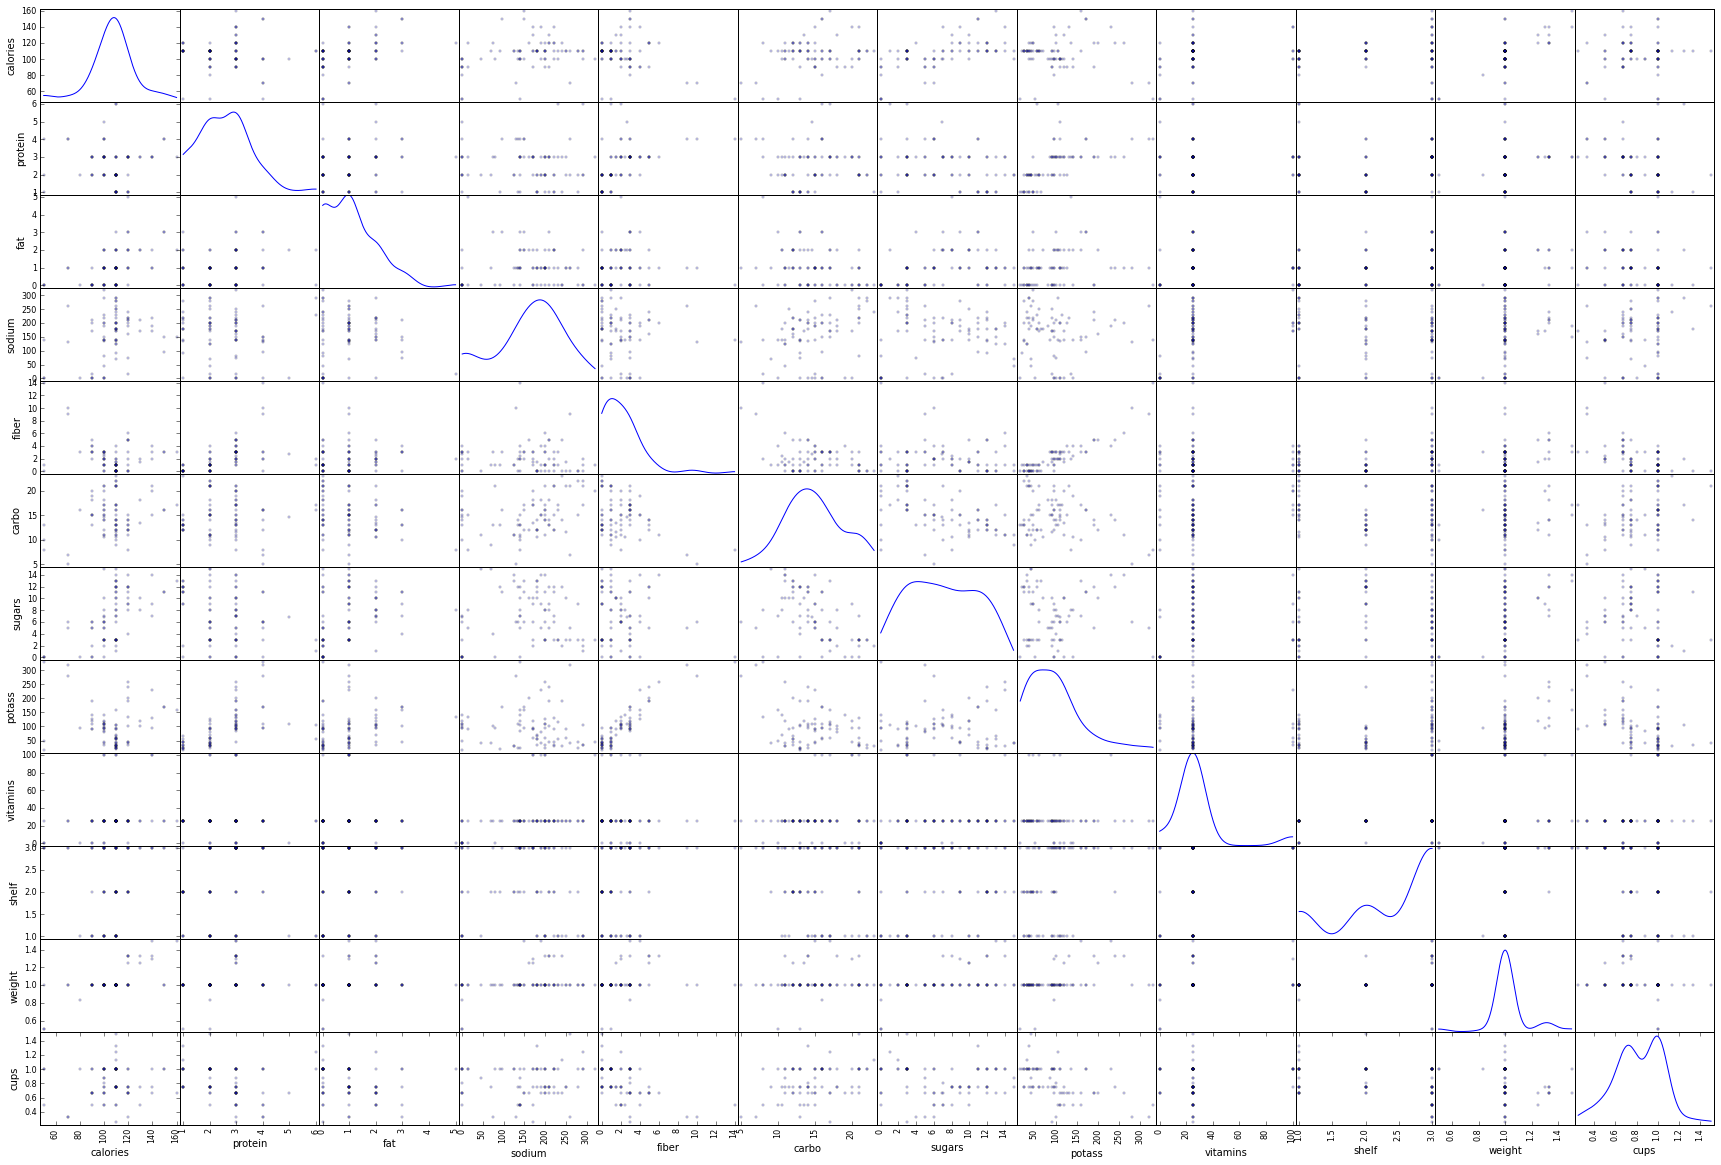

In [16]:
scatter_matrix(df, alpha=0.2, figsize=(30, 20), diagonal='kde');

In [17]:
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
68,Strawberry_Fruit_Wheats,N,C,90,2,0,15,3,15,5,90,25,2,1.00,1.00
40,Kix,G,C,110,2,1,260,0,21,3,40,25,2,1.00,1.50
28,Fruitful_Bran,K,C,120,3,0,240,5,14,12,190,25,3,1.33,0.67
16,Corn_Flakes,K,C,100,2,0,290,1,21,2,35,25,1,1.00,1.00
63,Shredded_Wheat,N,C,80,2,0,0,3,16,0,95,0,1,0.83,1.00


In [18]:
for col in df.columns[3:]:
    df[col] = df[col] / df["weight"]
df = df.drop("weight", axis=1)

In [19]:
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,cups
68,Strawberry_Fruit_Wheats,N,C,90.000000,2.000000,0,15.000000,3.000000,15.000000,5.000000,90.000000,25.000000,2.000000,1.00
40,Kix,G,C,110.000000,2.000000,1,260.000000,0.000000,21.000000,3.000000,40.000000,25.000000,2.000000,1.50
28,Fruitful_Bran,K,C,90.225564,2.255639,0,180.451128,3.759398,10.526316,9.022556,142.857143,18.796992,2.255639,0.67
16,Corn_Flakes,K,C,100.000000,2.000000,0,290.000000,1.000000,21.000000,2.000000,35.000000,25.000000,1.000000,1.00
63,Shredded_Wheat,N,C,96.385542,2.409639,0,0.000000,3.614458,19.277108,0.000000,114.457831,0.000000,1.204819,1.00


## Preprocessing

In [21]:
df["mfr"].value_counts()

K    23
G    22
P     9
Q     8
R     8
N     6
A     1
dtype: int64

In [22]:
df["type"].value_counts()

C    74
H     3
dtype: int64

The hot/cold dichotomy seems to be insignificant enough to just drop. The "mfr" values are renumbered by prevelance, which might help to preserve some "distance" sense.

In [23]:
mfr_numbs = {
    "K":1,
    "G":2,
    "P":3,
    "R":4,
    "Q":5,
    "N":6,
    "A":7
}

In [24]:
df3 = df
df3["mfr"] = df["mfr"].apply(lambda val: mfr_numbs[val]) # applying the ennumeration scheme
df3 = df3.drop("type", axis=1)
df3 = df3.drop("name", axis=1)

In [25]:
df3["cups"].value_counts()

1.00    30
0.75    16
0.67    13
0.50     7
0.33     3
0.88     2
1.25     1
1.33     1
1.50     1
0.80     1
0.25     1
1.13     1
dtype: int64

In [26]:
df3.head() # these are all numbers now

,mfr,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,cups
68,6,90.000000,2.000000,0,15.000000,3.000000,15.000000,5.000000,90.000000,25.000000,2.000000,1.00
40,2,110.000000,2.000000,1,260.000000,0.000000,21.000000,3.000000,40.000000,25.000000,2.000000,1.50
28,1,90.225564,2.255639,0,180.451128,3.759398,10.526316,9.022556,142.857143,18.796992,2.255639,0.67
16,1,100.000000,2.000000,0,290.000000,1.000000,21.000000,2.000000,35.000000,25.000000,1.000000,1.00
63,6,96.385542,2.409639,0,0.000000,3.614458,19.277108,0.000000,114.457831,0.000000,1.204819,1.00


In [27]:
v4 = preprocessing.scale(df3) # converts dataframe to numpy array and does scaling

In [28]:
print(sum(v4[:,0]))
print(sum(v4[:,1]))

-2.33146835171e-15
3.44169137634e-15


In [34]:
df3.ix[:,"calories":].head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,cups
68,90.000000,2.000000,0,15.000000,3.000000,15.000000,5.000000,90.000000,25.000000,2.000000,1.00
40,110.000000,2.000000,1,260.000000,0.000000,21.000000,3.000000,40.000000,25.000000,2.000000,1.50
28,90.225564,2.255639,0,180.451128,3.759398,10.526316,9.022556,142.857143,18.796992,2.255639,0.67
16,100.000000,2.000000,0,290.000000,1.000000,21.000000,2.000000,35.000000,25.000000,1.000000,1.00
63,96.385542,2.409639,0,0.000000,3.614458,19.277108,0.000000,114.457831,0.000000,1.204819,1.00


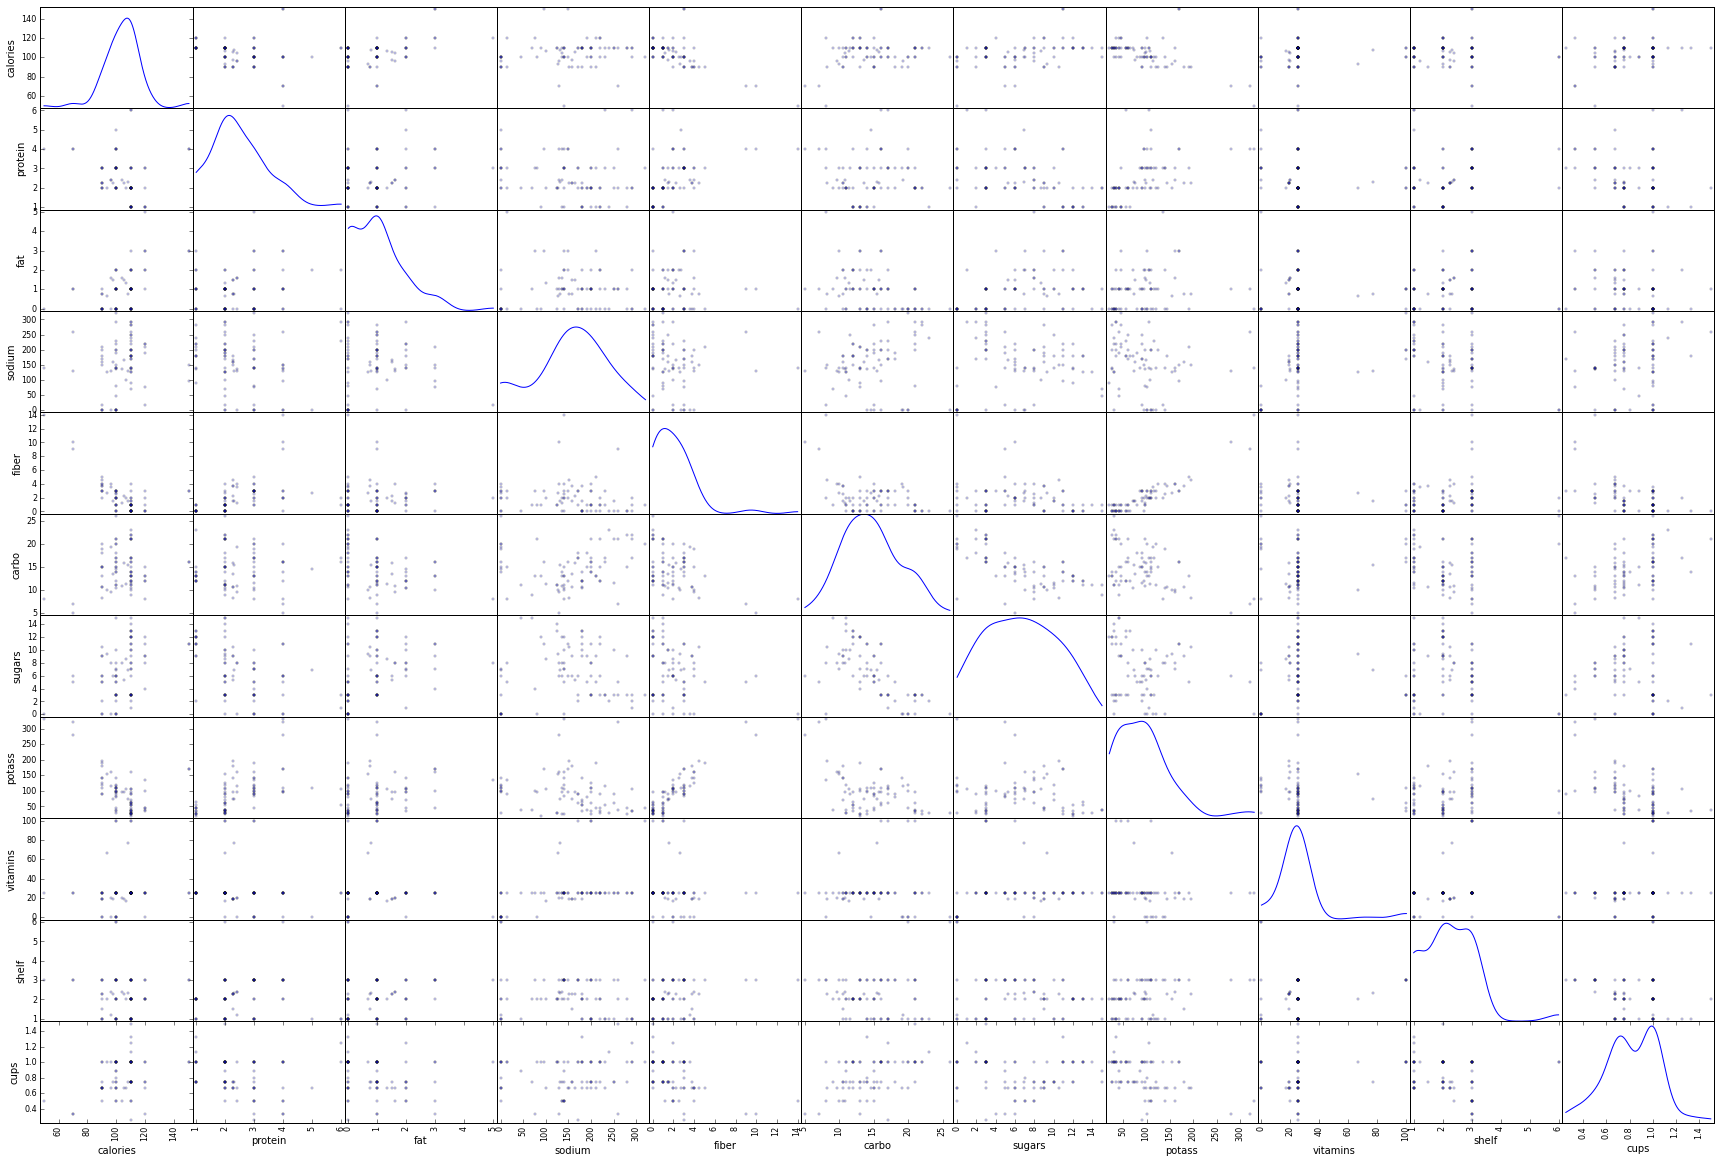

In [33]:
scatter_matrix(df3.ix[:,"calories":], alpha=0.2, figsize=(30, 20), diagonal='kde');

## Cluster Analysis

In [35]:
groups = pd.DataFrame(index=df.index)
groups["name"] = df["name"]
for i in range(2,10):
    kmeans = KMeans(i)
    kmeans.fit(v4)
    clusters = kmeans.predict(v4)
    col_name = "g"+(str(i).rjust(2)).replace(" ", "0")
    groups[col_name] = clusters

The above code actually applies the k-mean method to the data. But we have used a wide range of number of groups, from 2 to 10. Those were all stored into a dataframe so that we can later try to visualize and understand.

In [36]:
groups.head()

,name,g02,g03,g04,g05,g06,g07,g08,g09
68,Strawberry_Fruit_Wheats,1,0,1,0,3,1,2,6
40,Kix,0,2,0,3,2,3,3,5
28,Fruitful_Bran,1,0,2,4,1,5,0,2
16,Corn_Flakes,0,2,0,3,2,3,3,5
63,Shredded_Wheat,1,0,1,0,3,1,2,6


In [37]:
big_list = []
for i in range(2,10):
    col_val = groups.columns[i-1]
    lex_list = [[] for k in range(i)]
    for j in range(len(groups)):
        idx = groups[col_val][j]
#        print(idx)
        lex_list[idx].append(groups["name"][j])
    big_list.append(lex_list)

In [38]:
def print_big_list(lex_list):
    '''Organizes the groups from one trial (set number of groups) into a column-based printout'''
    Ncols = min(4, len(lex_list))
    sections = len(lex_list) // Ncols
    for k in range(sections):
        upper_lim = min((k+1)*4, len(lex_list))
        red_list = lex_list[k*4:upper_lim]
        MaxI = max([len(val) for val in lex_list])
        for j in range(Ncols):
            print((" Category "+str(j+k*4)).ljust(28), end="")
        print("")
        for i in range(MaxI):
            for j in range(Ncols):
                if i < len(red_list[j]):
                    print(red_list[j][i][:25].ljust(25)+"   ", end="")
                else:
                    print(" "*28, end="")
            print("")
        print("")
    

In [39]:
print_big_list(big_list[3])

 Category 0                  Category 1                  Category 2                  Category 3                 
Cream_of_Wheat_(Quick)      Apple_Cinnamon_Cheerios     100%_Bran                   Cheerios                    
Maypo                       Apple_Jacks                 All-Bran                    Corn_Chex                   
Puffed_Rice                 Cap'n'Crunch                All-Bran_with_Extra_Fiber   Corn_Flakes                 
Puffed_Wheat                Cinnamon_Toast_Crunch                                   Crispix                     
Quaker_Oatmeal              Cocoa_Puffs                                             Double_Chex                 
Shredded_Wheat              Corn_Pops                                               Just_Right_Crunchy__Nugge   
Shredded_Wheat_'n'Bran      Count_Chocula                                           Just_Right_Fruit_&_Nut      
Shredded_Wheat_spoon_size   Froot_Loops                                             Kix         

We have 4 columns here. A general eyeballing of the contents suggests categories of:
 - Generic flakes and Os
 - Sugar cereals
 - The "naturals" category
 - Exclusively fiber stuff

In [40]:
print_big_list(big_list[6])

 Category 0                  Category 1                  Category 2                  Category 3                 
Almond_Delight              Apple_Cinnamon_Cheerios     Cream_of_Wheat_(Quick)      Cheerios                    
Basic_4                     Apple_Jacks                 Maypo                       Corn_Chex                   
Bran_Chex                   Cap'n'Crunch                Quaker_Oatmeal              Corn_Flakes                 
Bran_Flakes                 Cinnamon_Toast_Crunch       Shredded_Wheat              Crispix                     
Clusters                    Cocoa_Puffs                 Shredded_Wheat_'n'Bran      Double_Chex                 
Cracklin'_Oat_Bran          Corn_Pops                   Shredded_Wheat_spoon_size   Kix                         
Crispy_Wheat_&_Raisins      Count_Chocula               Strawberry_Fruit_Wheats     Multi-Grain_Cheerios        
Frosted_Mini-Wheats         Froot_Loops                                             Nutri-grain_

Breaking it up into 8 categories, we see the emergence of new classes of cereals.
 - "Puff" cereals
 - Weight-loss cereals
 - Rains and dates
 - bran

# Predicting category of Bran flakes from Trader Joes

In [41]:
kmeans = KMeans(4)
kmeans.fit(v4)
clusters = kmeans.predict(v4)

lex_list = [[] for k in range(4)]
for j in range(len(clusters)):
    idx = clusters[j]
    lex_list[idx].append(df["name"][j])
print_big_list(lex_list)

 Category 0                  Category 1                  Category 2                  Category 3                 
All-Bran                    100%_Bran                   100%_Natural_Bran           Fruitful_Bran               
Bran_Chex                   Almond_Delight              All-Bran_with_Extra_Fiber   Shredded_Wheat_spoon_size   
Clusters                    Cap'n'Crunch                Apple_Cinnamon_Cheerios     Total_Corn_Flakes           
Corn_Flakes                 Cinnamon_Toast_Crunch       Apple_Jacks                                             
Corn_Pops                   Count_Chocula               Basic_4                                                 
Cracklin'_Oat_Bran          Double_Chex                 Bran_Flakes                                             
Cream_of_Wheat_(Quick)      Froot_Loops                 Cheerios                                                
Crispix                     Muesli_Raisins,_Dates,_&_   Cocoa_Puffs                             

In [42]:
df3.ix[0]

mfr           6.00
calories     70.00
protein       4.00
fat           1.00
sodium      130.00
fiber        10.00
carbo         5.00
sugars        6.00
potass      280.00
vitamins     25.00
shelf         3.00
cups          0.33
Name: 0, dtype: float64

In [43]:
kmeans.predict(df3.ix[0])

array([3], dtype=int32)

In [44]:
# Bran flakes data
BF = [6., 100., 3., 0.5, 220., 5., 24., 6., 170., 35., 3., 0.75]

In [45]:
kmeans.predict(BF)

array([3], dtype=int32)

It gets grouped in with the Corn Flakes and oatmeal cereal. That seems reasonable.

In [48]:
df3['group'] = clusters

In [49]:
df3.head()

,mfr,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,cups,group
68,6,90.000000,2.000000,0,15.000000,3.000000,15.000000,5.000000,90.000000,25.000000,2.000000,1.00,1
40,2,110.000000,2.000000,1,260.000000,0.000000,21.000000,3.000000,40.000000,25.000000,2.000000,1.50,2
28,1,90.225564,2.255639,0,180.451128,3.759398,10.526316,9.022556,142.857143,18.796992,2.255639,0.67,0
16,1,100.000000,2.000000,0,290.000000,1.000000,21.000000,2.000000,35.000000,25.000000,1.000000,1.00,2
63,6,96.385542,2.409639,0,0.000000,3.614458,19.277108,0.000000,114.457831,0.000000,1.204819,1.00,1


In [60]:
df3.columns[1:-1]

Index(['calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars',
       'potass', 'vitamins', 'shelf', 'cups'],
      dtype='object')

In [66]:
max(df3["group"])

3

In [76]:
df3.ix[28,"fiber"]

3.7593984962406015

In [68]:
group_df = pd.DataFrame([i for i in range(4)])

In [72]:
pd.Series([0 for i in range(4)])

0    0
1    0
2    0
3    0
dtype: int64

In [73]:
for col in df3.columns[1:-1]:
    group_df[col] = pd.Series([0 for i in range(4)])

In [75]:
group_df

,0,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,cups
0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0


In [79]:
for g in range(4):
    for col in df3.columns[1:-1]:
        s = df3[df3["group"] == g][col]
        group_df.ix[g,col] = sum(s)/len(s)

In [80]:
group_df

,0,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,cups
0,0,108.421053,2.097100,1.350269,146.373732,1.646575,12.330475,9.615467,88.304934,24.221864,2.103008,0.784524
1,1,96.638554,3.240964,0.400000,23.000000,2.131446,18.487451,2.092208,100.553575,7.500000,2.520482,0.851000
2,2,104.440559,2.695804,0.534965,222.762238,1.569930,18.335664,3.496503,72.185315,40.996503,2.104895,0.936364
3,3,63.333333,4.000000,0.666667,176.666667,11.000000,6.666667,3.666667,310.000000,25.000000,3.000000,0.386667


That final group has a dramatically larger amount of fiber compared to the others.